In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [3]:
data = np.load(r'C:\Users\angad\Downloads\XAI\dt.npy',mmap_mode='r')
labels = np.load(r'C:\Users\angad\Downloads\XAI\lb.npy',mmap_mode='r')

In [1]:
# Print loaded shapes
print(f"Loaded Data shape: {data.shape}")
print(f"Loaded Labels shape: {labels.shape}")

NameError: name 'data' is not defined

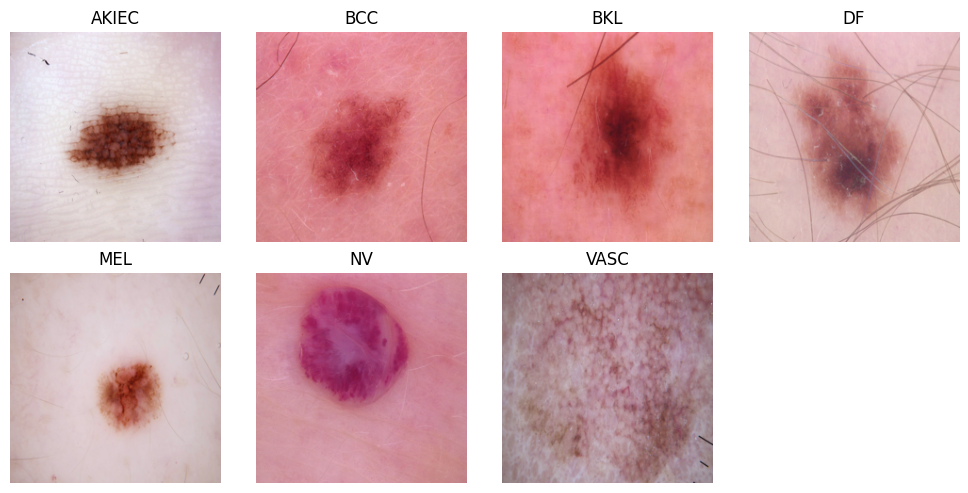

In [5]:
# Get unique class labels and their corresponding indices in the data array
unique_classes = np.unique(np.argmax(labels, axis=1))  # Get unique class indices from one-hot labels

# Create a dictionary to store one data sample from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Select one data sample from each class
for class_index in unique_classes:
    class_indices = np.where(np.argmax(labels, axis=1) == class_index)[0]  # Get indices for the current class
    class_samples[class_index] = data[class_indices[0]]  # Select the first sample for each class

# Plot the images in 2 rows
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
for i, (class_index, image_data) in enumerate(class_samples.items()):
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

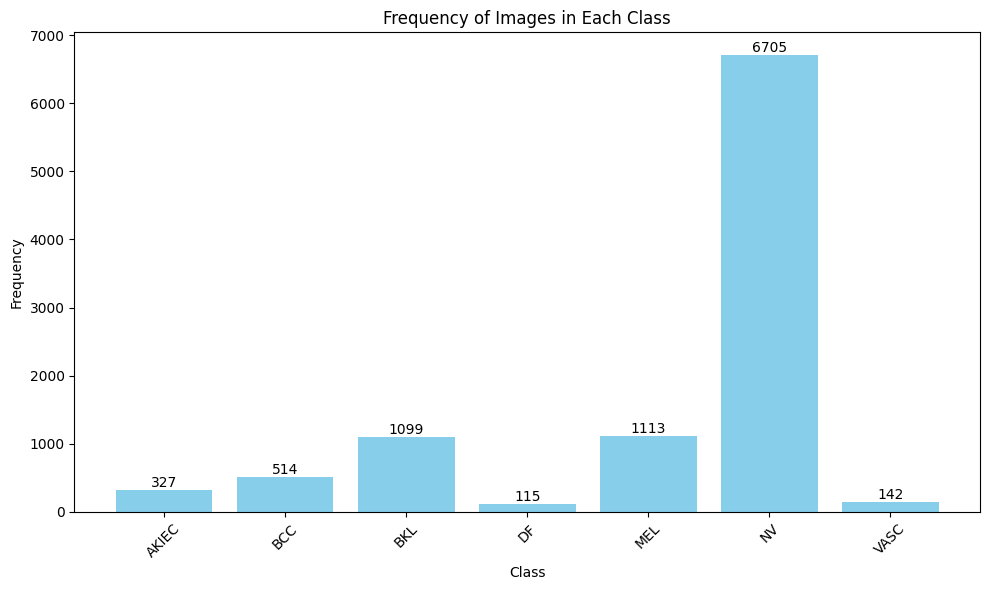

In [6]:
# Sum the one-hot encoded labels along the rows to get the frequency of each class
class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Plot the class frequencies
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Images in Each Class')

# Annotate the bars with the class frequencies (integer format)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# Paths
part_1_path = r'C:\Users\angad\Downloads\XAI\HAM10000_images_part_1'
part_2_path = r'C:\Users\angad\Downloads\XAI\HAM10000_images_part_2'
metadata_path = r'C:\Users\angad\Downloads\XAI\HAM10000_metadata.csv'

In [5]:
metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(
    lambda x: os.path.join(part_1_path, f'{x}.jpg') if os.path.exists(os.path.join(part_1_path, f'{x}.jpg')) 
    else os.path.join(part_2_path, f'{x}.jpg')
)

# Split into train and test
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)


In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # 20% of training data will be used as validation
)

# Load images and labels for train and validation sets
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)



Found 6410 validated image filenames belonging to 7 classes.


In [7]:
validation_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1602 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [12]:
from tensorflow.keras.applications import ResNet50

# Define and train ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

# Freeze base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Unfreeze base model layers for fine-tuning
for layer in resnet_base.layers:
    layer.trainable = True

# Fine-tune
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Save the ResNet50 model
resnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'ResNet50.h5'))


Epoch 1/10
201/201 [==============================] - 132s 599ms/step - loss: 1.1634 - accuracy: 0.6668 - val_loss: 1.1130 - val_accuracy: 0.6804
Epoch 2/10
201/201 [==============================] - 118s 585ms/step - loss: 1.1410 - accuracy: 0.6668 - val_loss: 1.1142 - val_accuracy: 0.6804
Epoch 3/10
201/201 [==============================] - 117s 584ms/step - loss: 1.1370 - accuracy: 0.6668 - val_loss: 1.1005 - val_accuracy: 0.6804
Epoch 4/10
201/201 [==============================] - 117s 584ms/step - loss: 1.1348 - accuracy: 0.6668 - val_loss: 1.1039 - val_accuracy: 0.6804
Epoch 5/10
201/201 [==============================] - 116s 579ms/step - loss: 1.1333 - accuracy: 0.6668 - val_loss: 1.0987 - val_accuracy: 0.6804
Epoch 6/10
201/201 [==============================] - 113s 562ms/step - loss: 1.1298 - accuracy: 0.6668 - val_loss: 1.1001 - val_accuracy: 0.6804
Epoch 7/10
201/201 [==============================] - 113s 562ms/step - loss: 1.1271 - accuracy: 0.6669 - val_loss: 1.1005 -

NameError: name 'model_save_path' is not defined

In [13]:
resnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'ResNet50.h5'))


In [7]:
### Load and Train ResNet50 Model ###
# Load the model
resnet_model_path = r'C:\Users\angad\Downloads\XAI\model\ResNet50.h5'
resnet_model = load_model(resnet_model_path)

# Compile the model for further training
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Continue training the model
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30  # Adjust number of epochs as needed
)

# Save the updated model
resnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model','ResNet50_Updated.h5'))


Epoch 1/30
201/201 [==============================] - 134s 598ms/step - loss: 0.2826 - accuracy: 0.8986 - val_loss: 0.4584 - val_accuracy: 0.8371
Epoch 2/30
201/201 [==============================] - 119s 591ms/step - loss: 0.2492 - accuracy: 0.9105 - val_loss: 0.4580 - val_accuracy: 0.8514
Epoch 3/30
201/201 [==============================] - 118s 587ms/step - loss: 0.2214 - accuracy: 0.9217 - val_loss: 0.4598 - val_accuracy: 0.8383
Epoch 4/30
201/201 [==============================] - 120s 596ms/step - loss: 0.2082 - accuracy: 0.9300 - val_loss: 0.4603 - val_accuracy: 0.8427
Epoch 5/30
201/201 [==============================] - 118s 586ms/step - loss: 0.1973 - accuracy: 0.9298 - val_loss: 0.4455 - val_accuracy: 0.8502
Epoch 6/30
201/201 [==============================] - 120s 594ms/step - loss: 0.1821 - accuracy: 0.9353 - val_loss: 0.4639 - val_accuracy: 0.8508
Epoch 7/30
201/201 [==============================] - 118s 588ms/step - loss: 0.1602 - accuracy: 0.9451 - val_loss: 0.4643 -

In [7]:
resnet_model_path = r'C:\Users\angad\Downloads\XAI\model\ResNet50_Updated.h5'
resnet_model = load_model(resnet_model_path)

# Compile the model for further training
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Continue training the model
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5  # Adjust number of epochs as needed
)

# Save the updated model
resnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model','ResNet50_Updated.h5'))


Epoch 1/5
201/201 [==============================] - 144s 648ms/step - loss: 0.0386 - accuracy: 0.9878 - val_loss: 0.5285 - val_accuracy: 0.8702
Epoch 2/5
201/201 [==============================] - 143s 712ms/step - loss: 0.0411 - accuracy: 0.9844 - val_loss: 0.5956 - val_accuracy: 0.8533
Epoch 3/5
201/201 [==============================] - 133s 660ms/step - loss: 0.0439 - accuracy: 0.9850 - val_loss: 0.5507 - val_accuracy: 0.8683
Epoch 4/5
201/201 [==============================] - 141s 700ms/step - loss: 0.0320 - accuracy: 0.9888 - val_loss: 0.5563 - val_accuracy: 0.8571
Epoch 5/5
201/201 [==============================] - 138s 683ms/step - loss: 0.0340 - accuracy: 0.9881 - val_loss: 0.5299 - val_accuracy: 0.8683


In [14]:
from tensorflow.keras.applications import Xception

# Define and train Xception
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = xception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

xception_model = Model(inputs=xception_base.input, outputs=predictions)

# Freeze base model layers
for layer in xception_base.layers:
    layer.trainable = False

# Compile the model
xception_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Unfreeze base model layers for fine-tuning
for layer in xception_base.layers:
    layer.trainable = True

# Fine-tune
xception_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

# Save the Xception model
xception_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'Xception.h5'))


Epoch 1/10
201/201 [==============================] - 119s 573ms/step - loss: 1.0773 - accuracy: 0.6484 - val_loss: 0.9192 - val_accuracy: 0.6904
Epoch 2/10
201/201 [==============================] - 113s 562ms/step - loss: 0.8899 - accuracy: 0.6916 - val_loss: 0.8364 - val_accuracy: 0.7035
Epoch 3/10
201/201 [==============================] - 113s 564ms/step - loss: 0.8347 - accuracy: 0.7092 - val_loss: 0.8063 - val_accuracy: 0.7129
Epoch 4/10
201/201 [==============================] - 115s 571ms/step - loss: 0.8037 - accuracy: 0.7120 - val_loss: 0.8032 - val_accuracy: 0.7266
Epoch 5/10
201/201 [==============================] - 113s 562ms/step - loss: 0.7727 - accuracy: 0.7278 - val_loss: 0.7677 - val_accuracy: 0.7266
Epoch 6/10
201/201 [==============================] - 113s 563ms/step - loss: 0.7487 - accuracy: 0.7363 - val_loss: 0.7637 - val_accuracy: 0.7310
Epoch 7/10
201/201 [==============================] - 113s 563ms/step - loss: 0.7455 - accuracy: 0.7370 - val_loss: 0.7552 -

In [8]:
### Load and Train Xception Model ###
# Load the model
xception_model_path = r'C:\Users\angad\Downloads\XAI\model\Xception.h5'
xception_model = load_model(xception_model_path)

# Compile the model for further training
xception_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Continue training the model
xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30  # Adjust number of epochs as needed
)

# Save the updated model
xception_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'Xception_Updated.h5'))


Epoch 1/30
201/201 [==============================] - 160s 739ms/step - loss: 0.3963 - accuracy: 0.8598 - val_loss: 0.4749 - val_accuracy: 0.8414
Epoch 2/30
201/201 [==============================] - 120s 597ms/step - loss: 0.3719 - accuracy: 0.8658 - val_loss: 0.4718 - val_accuracy: 0.8365
Epoch 3/30
201/201 [==============================] - 120s 595ms/step - loss: 0.3649 - accuracy: 0.8702 - val_loss: 0.4693 - val_accuracy: 0.8352
Epoch 4/30
201/201 [==============================] - 120s 598ms/step - loss: 0.3428 - accuracy: 0.8764 - val_loss: 0.4652 - val_accuracy: 0.8308
Epoch 5/30
201/201 [==============================] - 120s 594ms/step - loss: 0.3336 - accuracy: 0.8800 - val_loss: 0.4492 - val_accuracy: 0.8464
Epoch 6/30
201/201 [==============================] - 121s 603ms/step - loss: 0.3118 - accuracy: 0.8889 - val_loss: 0.4667 - val_accuracy: 0.8452
Epoch 7/30
201/201 [==============================] - 122s 607ms/step - loss: 0.2908 - accuracy: 0.8994 - val_loss: 0.4506 -

In [8]:
### Load and Train Xception Model ###
# Load the model
xception_model_path = r'C:\Users\angad\Downloads\XAI\model\Xception_Updated.h5'
xception_model = load_model(xception_model_path)

# Compile the model for further training
xception_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Continue training the model
xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5  # Adjust number of epochs as needed
)

# Save the updated model
xception_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'Xception_Updated.h5'))


Epoch 1/5
201/201 [==============================] - 165s 787ms/step - loss: 0.1097 - accuracy: 0.9638 - val_loss: 0.4275 - val_accuracy: 0.8714
Epoch 2/5
201/201 [==============================] - 124s 618ms/step - loss: 0.0926 - accuracy: 0.9674 - val_loss: 0.4214 - val_accuracy: 0.8645
Epoch 3/5
201/201 [==============================] - 116s 575ms/step - loss: 0.0933 - accuracy: 0.9676 - val_loss: 0.4520 - val_accuracy: 0.8677
Epoch 4/5
201/201 [==============================] - 117s 583ms/step - loss: 0.0821 - accuracy: 0.9716 - val_loss: 0.4585 - val_accuracy: 0.8664
Epoch 5/5
201/201 [==============================] - 115s 573ms/step - loss: 0.0867 - accuracy: 0.9691 - val_loss: 0.4498 - val_accuracy: 0.8689


In [9]:
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define and train EfficientNetV2M
efficientnet_base = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

# Freeze base model layers
for layer in efficientnet_base.layers:
    layer.trainable = False

# Compile the model
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Train the model
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Unfreeze base model layers for fine-tuning
for layer in efficientnet_base.layers:
    layer.trainable = True

# Fine-tune
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Save the EfficientNetV2M model
efficientnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'EfficientNetV2M.h5'))


Epoch 1/10
201/201 [==============================] - 159s 685ms/step - loss: 1.3175 - accuracy: 0.6587 - val_loss: 1.1179 - val_accuracy: 0.6804
Epoch 2/10
201/201 [==============================] - 119s 590ms/step - loss: 1.1497 - accuracy: 0.6668 - val_loss: 1.1132 - val_accuracy: 0.6804
Epoch 3/10
201/201 [==============================] - 121s 600ms/step - loss: 1.1433 - accuracy: 0.6668 - val_loss: 1.1094 - val_accuracy: 0.6804
Epoch 4/10
201/201 [==============================] - 118s 586ms/step - loss: 1.1414 - accuracy: 0.6668 - val_loss: 1.1092 - val_accuracy: 0.6804
Epoch 5/10
201/201 [==============================] - 118s 586ms/step - loss: 1.1426 - accuracy: 0.6668 - val_loss: 1.1086 - val_accuracy: 0.6804
Epoch 6/10
201/201 [==============================] - 116s 575ms/step - loss: 1.1428 - accuracy: 0.6668 - val_loss: 1.1074 - val_accuracy: 0.6804
Epoch 7/10
201/201 [==============================] - 116s 577ms/step - loss: 1.1404 - accuracy: 0.6668 - val_loss: 1.1066 -

In [7]:
efficientnet_model_path = r'C:\Users\angad\Downloads\XAI\model\EfficientNetV2M.h5'
efficientnet_model = load_model(efficientnet_model_path)

# Compile the model for further training
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Continue training the model
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30 # Adjust number of epochs as needed
)

# Save the updated model
efficientnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'EfficientNetV2M_Updated.h5'))

Epoch 1/30
201/201 [==============================] - 203s 815ms/step - loss: 0.5039 - accuracy: 0.8181 - val_loss: 0.5405 - val_accuracy: 0.7965
Epoch 2/30
201/201 [==============================] - 158s 784ms/step - loss: 0.4938 - accuracy: 0.8201 - val_loss: 0.5228 - val_accuracy: 0.8115
Epoch 3/30
201/201 [==============================] - 165s 820ms/step - loss: 0.4738 - accuracy: 0.8270 - val_loss: 0.5707 - val_accuracy: 0.8059
Epoch 4/30
201/201 [==============================] - 158s 783ms/step - loss: 0.4472 - accuracy: 0.8395 - val_loss: 0.5275 - val_accuracy: 0.8027
Epoch 5/30
201/201 [==============================] - 160s 793ms/step - loss: 0.4155 - accuracy: 0.8502 - val_loss: 0.5163 - val_accuracy: 0.8109
Epoch 6/30
201/201 [==============================] - 158s 785ms/step - loss: 0.4051 - accuracy: 0.8516 - val_loss: 0.5080 - val_accuracy: 0.8152
Epoch 7/30
201/201 [==============================] - 162s 806ms/step - loss: 0.3878 - accuracy: 0.8619 - val_loss: 0.4699 -

In [8]:
efficientnet_model_path = r'C:\Users\angad\Downloads\XAI\model\EfficientNetV2M_Updated.h5'
efficientnet_model = load_model(efficientnet_model_path)

# Compile the model for further training
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Continue training the model
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5  # Adjust number of epochs as needed
)

# Save the updated model
efficientnet_model.save(os.path.join(r'C:\Users\angad\Downloads\XAI\model', 'EfficientNetV2M_Updated.h5'))

Epoch 1/5
201/201 [==============================] - 218s 883ms/step - loss: 0.1122 - accuracy: 0.9616 - val_loss: 0.5123 - val_accuracy: 0.8508
Epoch 2/5
201/201 [==============================] - 166s 823ms/step - loss: 0.1060 - accuracy: 0.9615 - val_loss: 0.4515 - val_accuracy: 0.8627
Epoch 3/5
201/201 [==============================] - 165s 818ms/step - loss: 0.1005 - accuracy: 0.9666 - val_loss: 0.5513 - val_accuracy: 0.8452
Epoch 4/5
201/201 [==============================] - 165s 820ms/step - loss: 0.1059 - accuracy: 0.9637 - val_loss: 0.5605 - val_accuracy: 0.8433
Epoch 5/5
201/201 [==============================] - 165s 819ms/step - loss: 0.0854 - accuracy: 0.9724 - val_loss: 0.4738 - val_accuracy: 0.8633


In [9]:
efficientnet_model = load_model(r'C:\Users\angad\Downloads\XAI\model\EfficientNetV2M_Updated.h5')
resnet_model = load_model(r'C:\Users\angad\Downloads\XAI\model\ResNet50_Updated.h5')
xception_model = load_model(r'C:\Users\angad\Downloads\XAI\model\Xception_Updated.h5')

def evaluate_model(model, model_name):

    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f'{model_name} Test Accuracy: {test_accuracy * 100:.2f}%')
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

print("Evaluating EfficientNetV2M...")
evaluate_model(efficientnet_model, 'EfficientNetV2M')

print("Evaluating ResNet50...")
evaluate_model(resnet_model, 'ResNet50')

print("Evaluating Xception...")
evaluate_model(xception_model, 'Xception')

Evaluating EfficientNetV2M...
63/63 [==============================] - 18s 199ms/step - loss: 0.5917 - accuracy: 0.8412
EfficientNetV2M Test Accuracy: 84.12%
63/63 [==============================] - 19s 206ms/step

Classification Report for EfficientNetV2M:
              precision    recall  f1-score   support

       akiec       0.89      0.38      0.54        65
         bcc       0.86      0.63      0.73       103
         bkl       0.70      0.72      0.71       220
          df       0.83      0.65      0.73        23
         mel       0.54      0.78      0.63       223
          nv       0.94      0.91      0.93      1341
        vasc       0.89      0.86      0.87        28

    accuracy                           0.84      2003
   macro avg       0.81      0.71      0.73      2003
weighted avg       0.86      0.84      0.84      2003

Evaluating ResNet50...
63/63 [==============================] - 14s 198ms/step - loss: 0.8590 - accuracy: 0.8258
ResNet50 Test Accuracy: 82.58%
6

In [14]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the individual models
efficientnet_model = load_model(r'C:\Users\angad\Downloads\XAI\model\EfficientNetV2M_Updated.h5')
resnet_model = load_model(r'C:\Users\angad\Downloads\XAI\model\ResNet50_Updated.h5')
xception_model = load_model(r'C:\Users\angad\Downloads\XAI\model\Xception_Updated.h5')

# Function to ensemble predictions (simple average)
def ensemble_predict(models, img_batch):
    predictions = [model.predict(img_batch) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Use the function to ensemble predictions from all models
models = [efficientnet_model, resnet_model, xception_model]
ensemble_predictions = ensemble_predict(models, test_generator)


63/63 [==============================] - 14s 202ms/step


In [18]:
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# LIME explainer for image classification
explainer = lime_image.LimeImageExplainer()

# Pick an image from the validation data
test_img, _ = validation_generator.next()
img = test_img[0]  # Select one image

# Explain the prediction
explanation = explainer.explain_instance(img.astype('double'), 
                                         lambda x: ensemble_predict(models, x), 
                                         top_labels=5, hide_color=0, num_samples=1000)

# Show the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 10/1000 [00:00<00:47, 20.95it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 20/1000 [00:00<00:42, 23.26it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 30/1000 [00:01<00:40, 24.15it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 40/1000 [00:01<00:39, 24.38it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 50/1000 [00:02<00:38, 24.73it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 60/1000 [00:02<00:37, 24.92it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 70/1000 [00:02<00:37, 24.90it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 80/1000 [00:03<00:36, 25.07it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 90/1000 [00:03<00:36, 24.81it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 100/1000 [00:04<00:36, 24.79it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 110/1000 [00:04<00:36, 24.32it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 120/1000 [00:04<00:36, 24.06it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 130/1000 [00:05<00:36, 23.93it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 140/1000 [00:05<00:36, 23.65it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 150/1000 [00:06<00:35, 23.80it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 160/1000 [00:06<00:35, 23.85it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 170/1000 [00:07<00:34, 23.74it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 180/1000 [00:07<00:34, 23.44it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 190/1000 [00:07<00:35, 22.74it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 200/1000 [00:08<00:35, 22.29it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 210/1000 [00:08<00:35, 22.47it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 220/1000 [00:09<00:34, 22.59it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 230/1000 [00:09<00:34, 22.55it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 240/1000 [00:10<00:32, 23.09it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 250/1000 [00:10<00:32, 23.31it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 260/1000 [00:10<00:30, 23.93it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 270/1000 [00:11<00:30, 24.19it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 280/1000 [00:11<00:29, 24.70it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 290/1000 [00:12<00:28, 25.14it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 300/1000 [00:12<00:28, 24.89it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 310/1000 [00:12<00:27, 24.81it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 320/1000 [00:13<00:27, 25.15it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 330/1000 [00:13<00:26, 25.08it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 340/1000 [00:14<00:26, 25.06it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 350/1000 [00:14<00:25, 25.00it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 360/1000 [00:14<00:26, 24.52it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 370/1000 [00:15<00:25, 24.81it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 380/1000 [00:15<00:24, 24.83it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 390/1000 [00:16<00:24, 24.80it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 400/1000 [00:16<00:24, 24.86it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 410/1000 [00:16<00:23, 25.06it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 420/1000 [00:17<00:23, 25.04it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 430/1000 [00:17<00:22, 24.96it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 440/1000 [00:18<00:22, 25.14it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 450/1000 [00:18<00:21, 25.14it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 460/1000 [00:18<00:21, 25.15it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 470/1000 [00:19<00:21, 25.22it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 480/1000 [00:19<00:20, 25.24it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 490/1000 [00:20<00:20, 24.45it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 500/1000 [00:20<00:20, 24.57it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 510/1000 [00:20<00:19, 24.79it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 520/1000 [00:21<00:19, 24.79it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 530/1000 [00:21<00:18, 24.93it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 540/1000 [00:22<00:19, 23.86it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 550/1000 [00:22<00:19, 23.07it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 560/1000 [00:23<00:18, 23.78it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 570/1000 [00:23<00:17, 24.29it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 580/1000 [00:23<00:17, 24.70it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 590/1000 [00:24<00:17, 24.05it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 600/1000 [00:24<00:16, 23.70it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 610/1000 [00:25<00:16, 23.70it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 620/1000 [00:25<00:15, 23.85it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 630/1000 [00:25<00:15, 24.23it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 640/1000 [00:26<00:14, 24.50it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 650/1000 [00:26<00:14, 24.63it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 660/1000 [00:27<00:13, 24.54it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 670/1000 [00:27<00:13, 24.38it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 680/1000 [00:28<00:13, 24.20it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 690/1000 [00:28<00:12, 24.11it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 700/1000 [00:28<00:12, 23.95it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 710/1000 [00:29<00:12, 23.53it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 720/1000 [00:29<00:12, 23.30it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 730/1000 [00:30<00:11, 23.28it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 740/1000 [00:30<00:11, 23.35it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 750/1000 [00:31<00:10, 23.62it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 760/1000 [00:31<00:10, 23.71it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 770/1000 [00:31<00:09, 23.76it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 780/1000 [00:32<00:09, 23.32it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 790/1000 [00:32<00:09, 23.15it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 800/1000 [00:33<00:08, 23.00it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 810/1000 [00:33<00:08, 23.06it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 820/1000 [00:34<00:07, 23.33it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 830/1000 [00:34<00:07, 23.39it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 840/1000 [00:34<00:06, 23.31it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 850/1000 [00:35<00:06, 23.18it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 860/1000 [00:35<00:06, 22.93it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 870/1000 [00:36<00:05, 22.79it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 880/1000 [00:36<00:05, 22.85it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 890/1000 [00:37<00:04, 23.14it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 900/1000 [00:37<00:04, 23.06it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 910/1000 [00:37<00:03, 23.01it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 920/1000 [00:38<00:03, 23.11it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 930/1000 [00:38<00:02, 23.39it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 940/1000 [00:39<00:02, 23.45it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 950/1000 [00:39<00:02, 23.57it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 960/1000 [00:40<00:01, 23.78it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 970/1000 [00:40<00:01, 23.47it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 980/1000 [00:40<00:00, 23.37it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 990/1000 [00:41<00:00, 23.14it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 1000/1000 [00:41<00:00, 23.92it/s]


TypeError: solve() got an unexpected keyword argument 'sym_pos'

In [21]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Load your pre-trained ResNet50 model
model = load_model(r'C:\Users\angad\Downloads\XAI\model\ResNet50_Updated.h5')


In [29]:
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image

explainer = lime_image.LimeImageExplainer()
def predict_fn(images):
    processed_images = np.vstack([img[np.newaxis, :, :, :] for img in images])
    predictions = model.predict(processed_images)
    return predictions


In [31]:
def explain_lime(image_path, model):
    image_path=r'C:\Users\angad\Downloads\XAI\ISIC_0024306.jpg'
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img) / 255.0

    # Run LIME explanation
    explanation = explainer.explain_instance(img.astype('double'),
                                             predict_fn,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)

    # Display explanation for the top class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=5,
                                                hide_rest=False)

    # Show the image with explanation boundaries
    img_boundry = mark_boundaries(temp / 255.0, mask)
    plt.imshow(img_boundry)
    plt.axis('off')
    plt.show()

# Example usage for LIME
explain_lime(r'C:\Users\angad\Downloads\XAI\ISIC_0024306.jpg', model)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 10/1000 [00:00<00:45, 21.92it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 20/1000 [00:00<00:26, 36.69it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 30/1000 [00:00<00:20, 46.76it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 40/1000 [00:00<00:17, 54.14it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 50/1000 [00:01<00:16, 58.19it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 60/1000 [00:01<00:15, 61.45it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:01<00:14, 63.98it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 80/1000 [00:01<00:14, 65.49it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 90/1000 [00:01<00:14, 64.78it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 100/1000 [00:01<00:13, 65.88it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 110/1000 [00:01<00:13, 67.34it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 120/1000 [00:02<00:13, 67.27it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 130/1000 [00:02<00:12, 68.47it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 140/1000 [00:02<00:12, 68.76it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 68.80it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 68.02it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 65.86it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 180/1000 [00:02<00:12, 65.70it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 190/1000 [00:03<00:12, 64.70it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 200/1000 [00:03<00:12, 63.65it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 210/1000 [00:03<00:12, 64.28it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 220/1000 [00:03<00:12, 63.24it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 230/1000 [00:03<00:12, 62.54it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 240/1000 [00:03<00:12, 62.52it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 250/1000 [00:04<00:11, 62.51it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 260/1000 [00:04<00:11, 62.39it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 270/1000 [00:04<00:11, 63.01it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 280/1000 [00:04<00:11, 63.33it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 290/1000 [00:04<00:11, 62.72it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 300/1000 [00:04<00:11, 59.30it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 310/1000 [00:05<00:11, 58.95it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 320/1000 [00:05<00:11, 59.54it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 330/1000 [00:05<00:11, 60.61it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 61.14it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 350/1000 [00:05<00:10, 60.64it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 360/1000 [00:05<00:10, 59.97it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 370/1000 [00:06<00:10, 59.73it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 380/1000 [00:06<00:10, 60.31it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 390/1000 [00:06<00:09, 61.34it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 400/1000 [00:06<00:09, 60.23it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 410/1000 [00:06<00:09, 59.47it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 420/1000 [00:06<00:09, 59.91it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:07<00:09, 59.90it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 440/1000 [00:07<00:09, 60.87it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 450/1000 [00:07<00:08, 62.03it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 63.57it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 470/1000 [00:07<00:08, 63.97it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 480/1000 [00:07<00:08, 63.64it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 490/1000 [00:07<00:08, 63.41it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 500/1000 [00:08<00:08, 59.73it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 510/1000 [00:08<00:08, 60.53it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 520/1000 [00:08<00:07, 62.13it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 62.47it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 540/1000 [00:08<00:07, 62.59it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 550/1000 [00:08<00:07, 63.15it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 560/1000 [00:09<00:06, 63.55it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 570/1000 [00:09<00:06, 62.75it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 580/1000 [00:09<00:06, 63.51it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 63.08it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 600/1000 [00:09<00:06, 61.51it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 610/1000 [00:09<00:06, 60.02it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 620/1000 [00:10<00:06, 60.52it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 630/1000 [00:10<00:06, 60.54it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 640/1000 [00:10<00:05, 61.11it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 650/1000 [00:10<00:05, 61.52it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 660/1000 [00:10<00:05, 62.03it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 670/1000 [00:10<00:05, 62.17it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 680/1000 [00:11<00:05, 62.03it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 690/1000 [00:11<00:05, 61.59it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 700/1000 [00:11<00:05, 59.97it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 710/1000 [00:11<00:04, 60.04it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 59.56it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 730/1000 [00:11<00:04, 60.30it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 740/1000 [00:12<00:04, 59.95it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 750/1000 [00:12<00:04, 59.61it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 760/1000 [00:12<00:04, 59.79it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 770/1000 [00:12<00:03, 60.58it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 780/1000 [00:12<00:03, 60.80it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 790/1000 [00:12<00:03, 60.08it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 800/1000 [00:13<00:03, 60.89it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 810/1000 [00:13<00:03, 60.91it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 820/1000 [00:13<00:03, 58.27it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 830/1000 [00:13<00:02, 59.47it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 840/1000 [00:13<00:02, 59.48it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 60.57it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 860/1000 [00:14<00:02, 60.91it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 870/1000 [00:14<00:02, 57.07it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:14<00:02, 57.68it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 890/1000 [00:14<00:01, 57.31it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 900/1000 [00:14<00:01, 58.06it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [00:14<00:01, 58.80it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 920/1000 [00:15<00:01, 57.58it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 930/1000 [00:15<00:01, 57.64it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 940/1000 [00:15<00:01, 58.70it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 950/1000 [00:15<00:00, 58.94it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 960/1000 [00:15<00:00, 59.11it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 970/1000 [00:15<00:00, 59.98it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 980/1000 [00:16<00:00, 59.09it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 990/1000 [00:16<00:00, 59.75it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 1000/1000 [00:16<00:00, 60.71it/s]


TypeError: solve() got an unexpected keyword argument 'sym_pos'

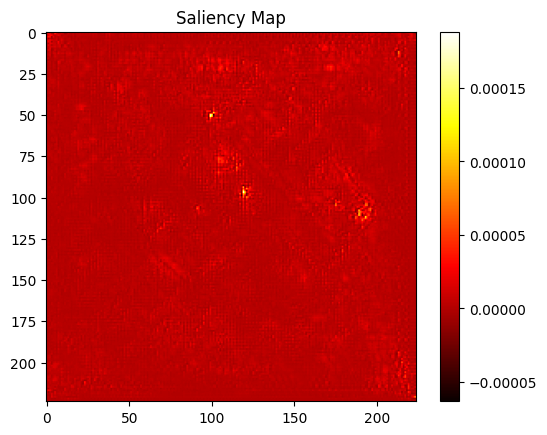

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_saliency(model, img):
    img_tensor = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_class = tf.argmax(predictions[0])
        loss = predictions[:, top_class]
    
    gradients = tape.gradient(loss, img_tensor)[0]
    gradients = tf.reduce_max(gradients, axis=-1)  # Take the maximum across the color channels
    return gradients.numpy()

# Compute saliency for a specific image
saliency = compute_saliency(efficientnet_model, img)

# Plot the saliency map
plt.imshow(saliency, cmap='hot')
plt.colorbar()
plt.title("Saliency Map")
plt.show()


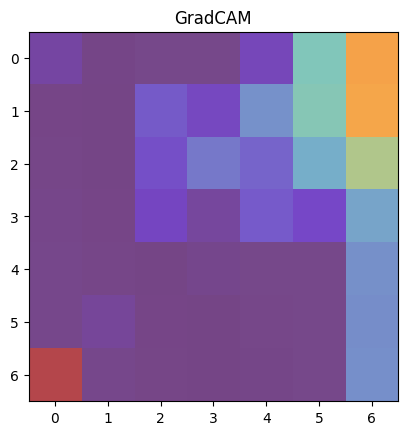

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_gradcam(model, img, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img[np.newaxis, ...])
        loss = predictions[:, tf.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads
    
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Apply GradCAM on the EfficientNetV2M model (for example)
last_conv_layer_name = 'top_conv'  # Change as needed for the specific model architecture
heatmap = get_gradcam(efficientnet_model, img, last_conv_layer_name)

# Overlay GradCAM on the original image
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap
plt.title("GradCAM")
plt.show()
